<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Семинар. Весна 2021</b></h3>

# Autoencoders. Часть 1





В этом ноутбуке мы сконструируем простой автоэнкодер и применим его для решения задачи детекции аномалий во временных рядах.

Напоминаем, что автоэнкодер имеет следующий вид:
![](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

Наша идея заключается в следующем: поскольку автоэнкодер выучивает распределение элементов обучающей выборки, он будет хорошо справляться с реконструкцией более вероятных объектов (т. е. тех, которые не являются аномалиями). Если же в тестовой выборке есть аномалия, то кодировщик реконструирует ее плохо, т. е. мы будем иметь большой лосс. Следовательно, будем считать аномалиями те объекты, лосс которых выше некоторого порога.

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

import seaborn as sns

sns.set(style='darkgrid', font_scale=1.2)

## Загрузка данных

Мы будем использовать датасет [Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) Это искусственно сгенерированный временной ряд с двумя признаками – `timestamp` и `value`

Для обучения мы возьмем файл `art_daily_small_noise.csv` (данные с маленьким шумом, без аномалий), а для теста возьмем
`art_daily_jumpsup.csv` (зашумленный, с аномалиями)

Загрузим наши датасеты:

In [ ]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

Посмотрим на то, как выглядят данные:

In [ ]:
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [ ]:
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


## Визуализация данных

Так выглядит временной ряд без аномалий (используется для обучения):

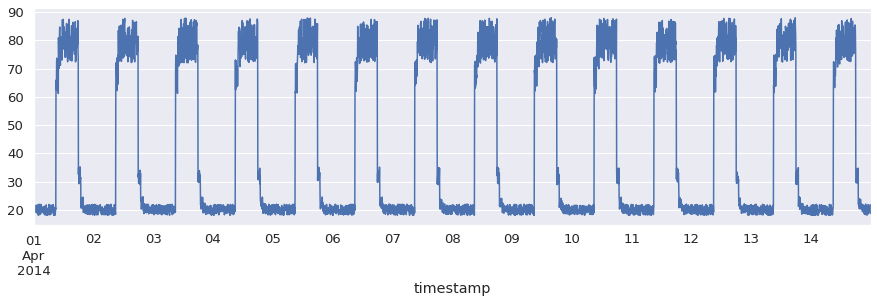

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
df_small_noise.plot(legend=False, ax=ax)
plt.show()

А так выглядят аномалии (на тесте):



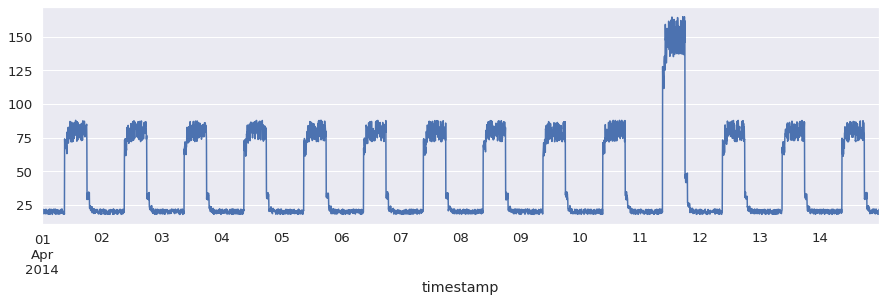

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

##  Обработка данных

Нормализуем значения признака
`value`. У нас есть `value` для 14 дней с периодичностью 5 минут

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total

In [ ]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std


Сгенерируем последовательности длительностью в 1 день **(288 time steps)**, а также разделим выборку на train и val:

In [ ]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return torch.FloatTensor(output).permute(0, 2, 1)


X = create_sequences(df_training_value.values)
x_train, x_val = train_test_split(X, test_size=0.9, shuffle=False)
print("Training input shape: ", x_train.shape)

train_loader = torch.utils.data.DataLoader(x_train, batch_size=4)
val_loader = torch.utils.data.DataLoader(x_val, batch_size=4)

Training input shape:  torch.Size([374, 1, 288])


## Построение модели

Мы будем строить сверточный автоэнкодер, принимающий на вход тензор размерности `(batch_size, sequence_length, num_features)` и возвращающий тензор такой же размерности. В нашем случае `sequence_length = 288` и
`num_features = 1`.

In [ ]:
class Autoencoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv1d(1, 32, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.Conv1d(32, 16, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose1d(16, 16, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.ConvTranspose1d(16, 32, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.ConvTranspose1d(32, 1, kernel_size=7, stride=1, padding=3),
    )

  def forward(self, sample):
    latent = self.encoder(sample)
    reconstructed = self.decoder(latent)
    return reconstructed

## Обучение

Заметим, что поскольку мы занимаемся реконструкцией, train/val у нас выступает как в роли входа для сети, так и в роли таргета

In [ ]:
n_epochs = 50
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.mse_loss
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed = model(X_batch.to(device))
        loss = loss_fn(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed = model(X_batch.to(device))
          loss = loss_fn(reconstructed, X_batch.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


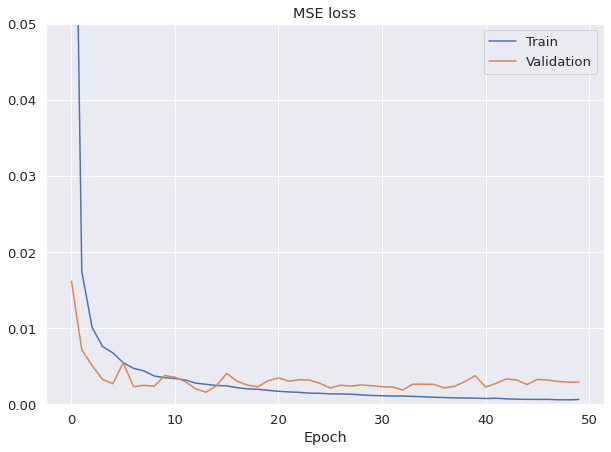

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(0, 0.05)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

## Детекция аномалий

Как мы уже говорили раньше, мы будем детектировать аномалии на основании того, насколько хорошо сеть воссоздает исходную последовательность. Более подробно


1.   Посчитаем MAE на трейне.
2.   Найдем максимум MAE на трейне. Это будет нашим порогом (`threshold`) для детекции (мы считаем, что на трейне аномалий нет)
3.   Если лосс больше `threshold`, то скорее всего у нас встретился паттерн, который автоэнкодер не видел при обучении. Будем считать его аномалией


In [ ]:
X_loader = torch.utils.data.DataLoader(X, batch_size=1)
model.eval()
threshold = 0.0
x_pred = []

with torch.no_grad():
  for batch in X_loader:
    pred = model(batch.to(device)).cpu().numpy()
    x_pred.append(pred.ravel())
    mae_loss = np.mean(np.abs(pred - batch.numpy()))

    if mae_loss > threshold:
      threshold = mae_loss

print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.039144903


Давайте посмотрим, насколько хорошо наша модель воспроизводит данные с первого для:

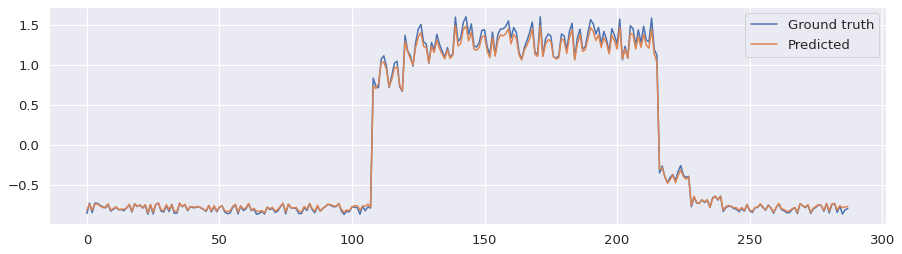

In [ ]:
# Checking how the first sequence is learnt
plt.figure(figsize=(15, 4))
plt.plot(x_train[0].numpy().ravel(), label='Ground truth')
plt.plot(x_pred[0], label='Predicted')

plt.legend()
plt.show()

### Детекция на тестовых данных

Проделаем все, о чем мы говорили раньше:

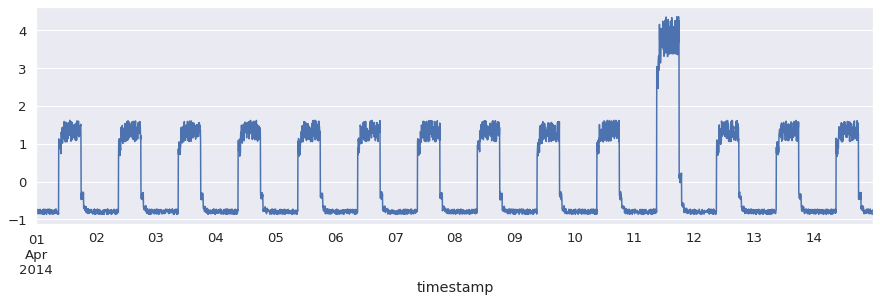

Test input shape:  torch.Size([3744, 1, 288])


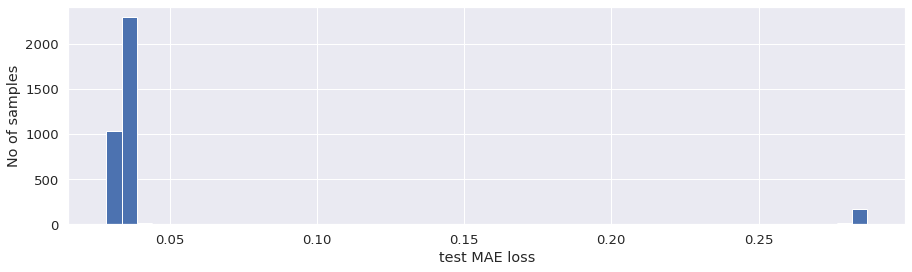

Number of anomaly samples:  405
Indices of anomaly samples:  (array([ 971,  973,  976, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708,
       2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719,
       2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730,
       2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741,
       2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752,
       2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763,
       2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774,
       2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785,
       2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796,
       2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807,
       2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818,
       2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829,
       2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2

In [ ]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots(figsize=(15, 4))
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
test_loader = torch.utils.data.DataLoader(x_test, shuffle=False)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.

test_losses = []
with torch.no_grad():
  for batch in test_loader:
    pred = model(batch.to(device)).cpu().numpy()
    mae_loss = np.mean(np.abs(pred - batch.numpy()))
    test_losses.append(mae_loss)

test_losses = np.array(test_losses).reshape((-1))

plt.figure(figsize=(15, 4))
plt.hist(test_losses, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_losses > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Как мы видим, некоторые индексы помечены как аномальные. Давайте теперь определим границы аномалий и изобразим их на графике

## Графики аномалий

Теперь мы хотим найти аномальные `timestamps` из теста. Будем делать так:

Пусть к примеру `time_steps = 3` и в нашей выборке 10 значений. Наш `x_train` будет выглядеть так:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

Все значения, кроме начального и последних `time_steps - 1`, появятся в данных
`time_steps` number of samples.  Поэтому, если мы знаем, что последовательности
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] – это аномалии, мы можем сказать, что аномалия произошла в момент времени 5

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Изобразим на графике тестовые данные

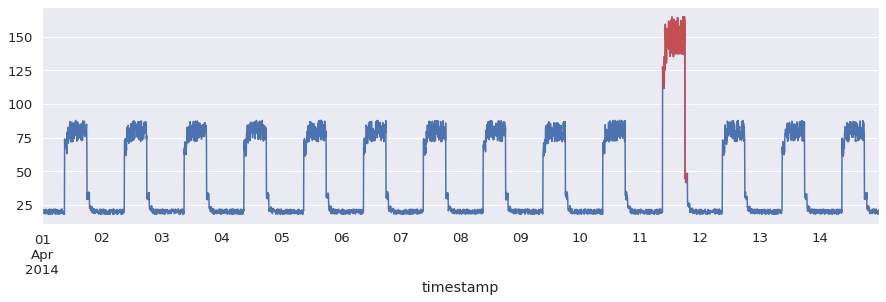

In [ ]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots(figsize=(15, 4))
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()